<div class="usecase-title">Public Event Planning</div>

<div class="usecase-authors"><b>Authored by: </b> Samiha Haque</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Data Visualization, Data Wrangling, Machine Learning Models, Geographical Coordinate Handling</div>
    
</div>

<div class="usecase-section-header">Scenario</div>

- As an event planner, I want to know the locations of past public events so that I can run my own public events - sport/promotion/music/filming/photo shoot/memorial/public holiday with ease.

- As an event planner, I want to know about available parking areas near the events so that my guests can park their cars with ease.

- As an event planner, I want to know closest banner spots near my events so that I can promote my events successfully

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Learn to work with categorical locations and geolocations using geopy
- Learn to plot multiple geolocations on a map using folium
- Learn to find nearest neighbours using KNeighborsRegressor and NearestNeighbors

<div class="usecase-section-header"><b>Business Friendy and Digitally Connected City</b></div>

The two of the eight priorities of the Economic Development Strategy 2031 of the city of Melbourne is to create a business friendly city and to develop a digitally connected city. By supporting businesses like event planning will help to drive the economy recovery and also help to map and connect public events, parkings and promotions through out the city of Melboune.

Datasets used:

- [Event permits 2014-2018 including film shoots, photo shoots, weddings, Christmas parties, promotions, fun runs and public events](https://data.melbourne.vic.gov.au/explore/dataset/event-permits-2014-2018-including-film-shoots-photo-shoots-weddings-christmas-pa/information/)<br>
This dataset mainly contains the category, start date, end date and categorical location of different events that get permits throughout the city of Melbourne. This dataset is used to identify the locations where each category of events take place.</p>
- [On-street Parking Bay Sensors](https://data.melbourne.vic.gov.au/explore/dataset/on-street-parking-bay-sensors/information/)<br>
This dataset mainly contains the zone number, status and geolocation  of parking spots throughout the city of Melbourne. This dataset is used to find the nearest parking spots around any given event.</p>
- [Bookable Banner Poles](https://data.melbourne.vic.gov.au/explore/dataset/bookable-banner-poles/information/)<br>
This dataset mainly contains the type, geolocation and booking group of five types of banners throughout the city of Melbourne which are 2.0, 4.0, 5.0, 6.0, 7.0 and 8.0. This dataset is used to find the nearest location of banners given any event location for promotional activities.</p>

In [62]:
!pip install geopy

     |████████████████████████████████| 125 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 13.2 MB/s eta 0:00:01


In [108]:
!pip install folium

     |████████████████████████████████| 100 kB 4.8 MB/s ta 0:00:01
     |████████████████████████████████| 56 kB 6.3 MB/s eta 0:00:011
     |████████████████████████████████| 133 kB 5.8 MB/s eta 0:00:01
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 1.1.1
    Uninstalling MarkupSafe-1.1.1:
      Successfully uninstalled MarkupSafe-1.1.1
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.
cookiecutter 1.7.2 requires Jinja2<3.0.0, but you have jinja2 3.1.3 which is incompatible.
cookiecutter 1.7.2 requires MarkupSafe<2.0.0, but you have markupsafe 2.1.5 which is incompatible.


In [880]:
!pip install retrying
import retrying

In [1795]:
#importing dependencies
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from decimal import Decimal
from io import StringIO
import geopy
from geopy.geocoders import Nominatim
import folium
from ipywidgets import interact, widgets
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from category_encoders.binary import BinaryEncoder

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor

In [1713]:
base_url='https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id='bookable-banner-poles'


url=f'{base_url}{dataset_id}/exports/csv'
params={'select':'*','limit':-1,'lang':'en','timezone':'UTC'}

response=requests.get(url,params=params)

if response.status_code==200:
    url_content=response.content.decode('utf-8')
    banner_df=pd.read_csv(StringIO(url_content),delimiter=';')
    print(banner_df.head(10))
else:
    print(f'Request failed with status code {response.status_code}')

   asset_number                                  asset_description  \
0       1110368  Standard Banner Pole - Lansdowne St: Wellingto...   
1       1110057                    Banner Pole - Super Banner Pole   
2       1110093                    Banner Pole - Super Banner Pole   
3       1110096                    Banner Pole - Super Banner Pole   
4       1110108                    Banner Pole - Super Banner Pole   
5       1350904                    Banner Pole - Super Banner Pole   
6       1110027                    Banner Pole - Super Banner Pole   
7       1110286  Super Banner Pole - Bourke St: Exhibition St -...   
8       1110544  Standard Banner Pole - Lonsdale St: Elizabeth ...   
9       1110418  Standard Banner Pole - Errol St: Victoria St -...   

   banner_pole_type  book_group             model_descr_lupvalue  \
0               6.0        62.0    Banner Pole - Standard Banner   
1               2.0        79.0  Banner Pole - Super Banner Pole   
2               2.0      

In [1687]:
base_url='https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id='on-street-parking-bay-sensors'


url=f'{base_url}{dataset_id}/exports/csv'
params={'select':'*','limit':-1,'lang':'en','timezone':'UTC'}

response=requests.get(url,params=params)

if response.status_code==200:
    url_content=response.content.decode('utf-8')
    parking_df=pd.read_csv(StringIO(url_content),delimiter=';')
    print(parking_df.head(10))
else:
    print(f'Request failed with status code {response.status_code}')

                 lastupdated           status_timestamp  zone_number  \
0  2023-12-14T04:45:34+00:00  2023-12-14T03:41:25+00:00       7695.0   
1  2023-12-14T04:45:34+00:00  2023-12-13T06:21:58+00:00       7939.0   
2  2023-12-14T04:45:34+00:00  2023-12-13T07:44:31+00:00          NaN   
3  2023-12-14T23:45:34+00:00  2023-12-14T23:35:02+00:00          NaN   
4  2023-12-14T23:45:34+00:00  2023-12-14T22:39:46+00:00          NaN   
5  2023-12-18T04:45:34+00:00  2023-12-17T23:47:54+00:00       7310.0   
6  2023-12-18T04:45:34+00:00  2023-11-02T00:47:52+00:00       7050.0   
7  2023-12-18T04:45:34+00:00  2023-12-18T04:03:50+00:00       7310.0   
8  2023-12-18T04:45:34+00:00  2023-12-18T03:40:13+00:00       7310.0   
9  2023-11-15T04:44:42+00:00  2023-11-15T01:35:58+00:00       7363.0   

  status_description  kerbsideid                                 location  
0         Unoccupied       22959   -37.81844776554182, 144.95938672872117  
1         Unoccupied       10136    -37.8099909364941, 

In [1355]:
base_url='https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id='event-permits-2014-2018-including-film-shoots-photo-shoots-weddings-christmas-pa'


url=f'{base_url}{dataset_id}/exports/csv'
params={'select':'*','limit':-1,'lang':'en','timezone':'UTC'}

response=requests.get(url,params=params)

if response.status_code==200:
    url_content=response.content.decode('utf-8')
    events_df=pd.read_csv(StringIO(url_content),delimiter=';')
    print(events_df.head(10))
else:
    print(f'Request failed with status code {response.status_code}')

                    title event_start   event_end       category_1  \
0         Holding The Man  2014-10-07  2014-10-07  Filming - Movie   
1  A Journey With Anthony  2015-03-07  2015-03-15  Filming - Movie   
2           Ali's Wedding  2015-12-03  2015-12-03  Filming - Movie   
3                Dogfight  2016-08-26  2016-08-27  Filming - Movie   
4               Old Timer  2016-04-20  2016-04-20  Filming - Movie   
5      Spirit Of The Game  2015-08-19  2015-08-20  Filming - Movie   
6                Dogfight  2016-09-17  2016-09-17  Filming - Movie   
7               Surya TVC  2014-04-26  2014-04-27  Filming - Other   
8           Threethousand  2014-05-06  2014-05-06  Filming - Other   
9        Loving Melbourne  2014-06-21  2014-06-21  Filming - Other   

            category_2                                           location  
0                  NaN                                       Fawkner Park  
1                  NaN       Other Park Locations, Inner Suburb Locations  
2

<b>EVENTS</b>

In [1356]:
events_df.head()

title event_start   event_end       category_1  \
0         Holding The Man  2014-10-07  2014-10-07  Filming - Movie   
1  A Journey With Anthony  2015-03-07  2015-03-15  Filming - Movie   
2           Ali's Wedding  2015-12-03  2015-12-03  Filming - Movie   
3                Dogfight  2016-08-26  2016-08-27  Filming - Movie   
4               Old Timer  2016-04-20  2016-04-20  Filming - Movie   

          category_2                                           location  
0                NaN                                       Fawkner Park  
1                NaN       Other Park Locations, Inner Suburb Locations  
2                NaN                             Inner Suburb Locations  
3                NaN  Flagstaff Gardens, Collins Street, Flinders La...  
4  Filming - Student                                       Fawkner Park

In [1357]:
events_df.shape

(2827, 6)

In [1358]:
events_df.nunique()

title          1877
event_start    1155
event_end      1150
category_1       34
category_2       11
location        619
dtype: int64

In [1359]:
events_df[['category_1']].value_counts()

category_1                             
Wedding                                    615
Public Event - Non-ticketed                446
Promotion                                  430
Filming - TV Series                        200
Public Event - Run Walk                    165
Filming - TVC                              158
Public Event - Ticketed                    111
Public Event - Low Impact Activity          92
Filming - Photo shoot                       90
Private Event                               87
Filming - Unit Base                         58
Filming - Student                           57
Public Event - Non Ticketed                 56
Public Event - Music Event                  41
Filming - Other                             40
Public Event - Media/Launch Event           36
Public Event - Run/Walk                     33
Public Event - Memorial                     25
Filming - Movie                             21
Public Event - Cycling Event                19
Public Event - Parad

<b>Handling null values</b>

In [1360]:
events_df.isna().sum() #category_2 has highest null values

title             0
event_start       0
event_end         4
category_1        0
category_2     2751
location          5
dtype: int64

In [1361]:
events_df[events_df['category_2'].notnull()][['category_1','category_2']].value_counts()
#Not much difference found between category_1 and category_2 values

category_1                          category_2           
Private Event                       Christmas Party          46
Filming - TV Series                 Filming - Unit            7
Public Event - Non-ticketed         Public                    7
Filming - Movie                     Filming - Unit Base       4
Filming - Photo shoot               Filming - Other           2
Filming - TVC                       Filming - Photo shoot     2
Filming - Movie                     Filming - Student         1
Filming - Photo shoot               Public Event              1
Filming - TVC                       Filming - Other           1
                                    Filming - TV Series       1
                                    Filming - Unit Base       1
Private Event -                     Christmas Party           1
Public Event - Low Impact Activity  Filming                   1
Public Event - Non-ticketed         Recrea                    1
dtype: int64

In [1362]:
events_df.drop(['title','category_2'],axis=1,inplace=True) #dropped category_2
events_df.head()

event_start   event_end       category_1  \
0  2014-10-07  2014-10-07  Filming - Movie   
1  2015-03-07  2015-03-15  Filming - Movie   
2  2015-12-03  2015-12-03  Filming - Movie   
3  2016-08-26  2016-08-27  Filming - Movie   
4  2016-04-20  2016-04-20  Filming - Movie   

                                            location  
0                                       Fawkner Park  
1       Other Park Locations, Inner Suburb Locations  
2                             Inner Suburb Locations  
3  Flagstaff Gardens, Collins Street, Flinders La...  
4                                       Fawkner Park

In [1363]:
events_df.isna().sum()

event_start    0
event_end      4
category_1     0
location       5
dtype: int64

In [1364]:
events_df[events_df['event_end'].isna()]

event_start event_end                               category_1  \
10    2014-12-08       NaN                          Filming - Other   
106   2016-02-25       NaN  Filming - TV Series Filming - TV Series   
418   2015-04-26       NaN              Public Event - Non-ticketed   
1559  2017-04-02       NaN                  Public Event - Ticketed   

                                               location  
10                                       Russell Street  
106   Alexandra Gardens, Kings Domain, All Other Spa...  
418                                         City Square  
1559                                       Kings Domain

In [1365]:
events_df.dropna(axis=0,inplace=True) #drop rows which have null values

In [1366]:
events_df.isna().sum()

event_start    0
event_end      0
category_1     0
location       0
dtype: int64

In [1367]:
events_df.shape

(2818, 4)

<b>Creating single location names for corresponding categories in each record</b>

In [1368]:
category=events_df['category_1'].unique()
category_dict={}
for i in category:
    val=events_df.loc[events_df['category_1']==i,['location','event_start','event_end']]
    category_dict[i]=val

In [1369]:
event_cat=[]
event_loc=[]
start_date=[]
end_date=[]
for i,j in category_dict.items():
    row=0
    for x in j['location']:
        if ", " in x:
            loc_lst=x.split(", ")
            for y in loc_lst:
                event_cat.append(i)
                start_date.append(j.iloc[row,1])
                end_date.append(j.iloc[row,2])
                event_loc.append(f"{y}, Melbourne, Australia")
        elif " - " in x:
            loc_lst=x.split(" - ")
            for y in loc_lst:
                event_cat.append(i)
                start_date.append(j.iloc[row,1])
                end_date.append(j.iloc[row,2])
                event_loc.append(f"{y}, Melbourne, Australia")
        else:
            event_cat.append(i)
            start_date.append(j.iloc[row,1])
            end_date.append(j.iloc[row,2])
            event_loc.append(f"{x}, Melbourne, Australia")
        row+=1

In [1370]:
events_loc_df=pd.DataFrame({'Events': event_cat, 'Location': event_loc,'Start_date':start_date,'End_date':end_date})
events_loc_df.head(10)

Events                                      Location  Start_date  \
0  Filming - Movie            Fawkner Park, Melbourne, Australia  2014-10-07   
1  Filming - Movie    Other Park Locations, Melbourne, Australia  2015-03-07   
2  Filming - Movie  Inner Suburb Locations, Melbourne, Australia  2015-03-07   
3  Filming - Movie  Inner Suburb Locations, Melbourne, Australia  2015-12-03   
4  Filming - Movie       Flagstaff Gardens, Melbourne, Australia  2016-08-26   
5  Filming - Movie          Collins Street, Melbourne, Australia  2016-08-26   
6  Filming - Movie           Flinders Lane, Melbourne, Australia  2016-08-26   
7  Filming - Movie   Little Collins Street, Melbourne, Australia  2016-08-26   
8  Filming - Movie           Market Street, Melbourne, Australia  2016-08-26   
9  Filming - Movie            Queen Street, Melbourne, Australia  2016-08-26   

     End_date  
0  2014-10-07  
1  2015-03-15  
2  2015-03-15  
3  2015-12-03  
4  2016-08-27  
5  2016-08-27  
6  2016-08-27  
7  2016-08-27  
8  2016-08-27  
9  2016-08-27

In [1371]:
events_loc_df.shape

(5132, 4)

<b>Converting location names to latitude,longitude coordinates using geolocator</b>

In [1372]:
@retrying.retry(wait_fixed=2000, stop_max_attempt_number=5)
def coordinates(location):
    loc = geolocator.geocode(location)
    if loc:
        return loc.latitude, loc.longitude
    else:
        raise Exception("Geocoding failed")


lat=[]
lon=[]
lookup_loc=[]
lookup_lat=[]
lookup_lon=[]

geolocator = Nominatim(user_agent="my_geocoder",timeout=5)


for i in events_loc_df['Location']:
    
    if i not in lookup_loc:
        
        try:
            l1,l2=coordinates(i)
  
            if l2:
                lat.append(l1)
                lon.append(l2)
                lookup_loc.append(i)
                lookup_lat.append(l1)
                lookup_lon.append(l2)
          
        except Exception as e:
            lat.append(i)
            lon.append(i)
            lookup_loc.append(i)
            lookup_lat.append(i)
            lookup_lon.append(i)
    else:
        ind=lookup_loc.index(i)
        
        lat.append(lookup_lat[ind])
        lon.append(lookup_lon[ind])
        
    

In [1373]:
len(lat),len(lon),len(event_cat)

(5132, 5132, 5132)

<b>New Dataframe with Category, Start_date, End_date, Latitude, Longitude and Location</b>

In [1374]:
events_lat_lon = pd.DataFrame({'Category': event_cat,'Start_date':start_date,'End_date':end_date, 'Latitude': lat,'Longitude':lon,'Location':event_loc})

In [1375]:
events_lat_lon.head()

Category  Start_date    End_date  \
0  Filming - Movie  2014-10-07  2014-10-07   
1  Filming - Movie  2015-03-07  2015-03-15   
2  Filming - Movie  2015-03-07  2015-03-15   
3  Filming - Movie  2015-12-03  2015-12-03   
4  Filming - Movie  2016-08-26  2016-08-27   

                                       Latitude  \
0                                    -37.841461   
1    Other Park Locations, Melbourne, Australia   
2  Inner Suburb Locations, Melbourne, Australia   
3  Inner Suburb Locations, Melbourne, Australia   
4                                    -37.810879   

                                      Longitude  \
0                                    144.981868   
1    Other Park Locations, Melbourne, Australia   
2  Inner Suburb Locations, Melbourne, Australia   
3  Inner Suburb Locations, Melbourne, Australia   
4                                    144.954607   

                                       Location  
0            Fawkner Park, Melbourne, Australia  
1    Other Park Locations, Melbourne, Australia  
2  Inner Suburb Locations, Melbourne, Australia  
3  Inner Suburb Locations, Melbourne, Australia  
4       Flagstaff Gardens, Melbourne, Australia

In [1297]:
# events_lat_lon.duplicated().sum()

39

In [1298]:
# events_lat_lon.drop_duplicates(keep='first', inplace=True)
# events_lat_lon.duplicated().sum()

0

<b>Checking latitude,longitude values which could not be converted to coordinates</b>

In [1376]:
events_lat_lon.loc[events_lat_lon['Latitude'].apply(lambda x: isinstance(x, str)),'Latitude'].value_counts()

Inner Suburb Locations, Melbourne, Australia                               273
Other Park Locations, Melbourne, Australia                                 140
Promotional Sites, Melbourne, Australia                                    140
Southbank Spillway, Melbourne, Australia                                   123
Roads / Public Access Spaces, Melbourne, Australia                          88
All Other Spaces, Melbourne, Australia                                      83
Bourke St Mall - next to Tourism booth, Melbourne, Australia                75
next to Tourism booth, Melbourne, Australia                                 57
Southbank Spillway , Melbourne, Australia                                   53
AG - Riverslide Skate Park, Melbourne, Australia                            38
Argyle Square Stage Only, Melbourne, Australia                              21
Meyers Place (Green Laneway), Melbourne, Australia                          13
Other Laneways/Places/Alleys, Melbourne, Australia  

<b>Manually converting few selected longitude, latitude coordinates(Assumed all inner suburbs as Carlton)</b>

In [1377]:
events_lat_lon.loc[events_lat_lon['Latitude']=='Bourke St Mall - next to Tourism booth, Melbourne, Australia','Latitude']=-37.811425719556375
events_lat_lon.loc[events_lat_lon['Longitude']=='Bourke St Mall - next to Tourism booth, Melbourne, Australia','Longitude']=144.9642798285428

events_lat_lon.loc[events_lat_lon['Latitude']=='AG - Riverslide Skate Park, Melbourne, Australia','Latitude']=-37.81740602754738
events_lat_lon.loc[events_lat_lon['Longitude']=='AG - Riverslide Skate Park, Melbourne, Australia','Longitude']=144.9729885581025

events_lat_lon.loc[events_lat_lon['Latitude']=='Argyle Square Stage Only, Melbourne, Australia','Latitude']=-37.79994933523437
events_lat_lon.loc[events_lat_lon['Longitude']=='Argyle Square Stage Only, Melbourne, Australia','Longitude']=144.9668979307423

events_lat_lon.loc[events_lat_lon['Latitude']=='Meyers Place (Green Laneway), Melbourne, Australia','Latitude']=-37.809521131914906
events_lat_lon.loc[events_lat_lon['Longitude']=='Meyers Place (Green Laneway), Melbourne, Australia','Longitude']=144.97168456715806

events_lat_lon.loc[events_lat_lon['Latitude']=='BM Birrarung Marr, Melbourne, Australia','Latitude']=-37.819058
events_lat_lon.loc[events_lat_lon['Longitude']=='BM Birrarung Marr, Melbourne, Australia','Longitude']=144.974327

events_lat_lon.loc[events_lat_lon['Latitude']=='NMCC Soccer, Melbourne, Australia','Latitude']=-37.79280741138573
events_lat_lon.loc[events_lat_lon['Longitude']=='NMCC Soccer, Melbourne, Australia','Longitude']=144.93997444199712

events_lat_lon.loc[events_lat_lon['Latitude']=='Southern Cross Pedestrian Bridge, Melbourne, Australia','Latitude']=-37.815430188169096
events_lat_lon.loc[events_lat_lon['Longitude']=='Southern Cross Pedestrian Bridge, Melbourne, Australia','Longitude']=144.95278728089147

events_lat_lon.loc[events_lat_lon['Latitude']=='Chinatown Plaza, Melbourne, Australia','Latitude']=-37.81055582784353
events_lat_lon.loc[events_lat_lon['Longitude']=='Chinatown Plaza, Melbourne, Australia','Longitude']=144.96919346931784

events_lat_lon.loc[events_lat_lon['Latitude']=='Chinatown Plaza - see notes., Melbourne, Australia','Latitude']=-37.81055582784353
events_lat_lon.loc[events_lat_lon['Longitude']=='Chinatown Plaza - see notes., Melbourne, Australia','Longitude']=144.96919346931784

events_lat_lon.loc[events_lat_lon['Latitude']=='Northbank Promenade, Melbourne, Australia','Latitude']=-37.81883297899373
events_lat_lon.loc[events_lat_lon['Longitude']=='Northbank Promenade, Melbourne, Australia','Longitude']=144.93761358465892

events_lat_lon.loc[events_lat_lon['Latitude']=='Katherine Place (Green Laneway), Melbourne, Australia','Latitude']=-37.81333297388235
events_lat_lon.loc[events_lat_lon['Longitude']=='Katherine Place (Green Laneway), Melbourne, Australia','Longitude']=144.95689812465994

events_lat_lon.loc[events_lat_lon['Latitude']=='Bourke Street Mall - outfront of Adidas , Melbourne, Australia','Latitude']=-37.810705051858356
events_lat_lon.loc[events_lat_lon['Longitude']=='Bourke Street Mall - outfront of Adidas , Melbourne, Australia','Longitude']=144.96585977852442

events_lat_lon.loc[events_lat_lon['Latitude']=='Guildford Lane (Green Laneway(, Melbourne, Australia','Latitude']=-37.80945842151978
events_lat_lon.loc[events_lat_lon['Longitude']=='Guildford Lane (Green Laneway(, Melbourne, Australia','Longitude']=144.95981316261063

events_lat_lon.loc[events_lat_lon['Latitude']=='Straughton Lane, Melbourne, Australia','Latitude']=-37.81535364281512
events_lat_lon.loc[events_lat_lon['Longitude']=='Straughton Lane, Melbourne, Australia','Longitude']=144.96409712401254

events_lat_lon.loc[events_lat_lon['Latitude']=='Drewery Alley Drewery Lane, Melbourne, Australia','Latitude']=-37.808345973082375
events_lat_lon.loc[events_lat_lon['Longitude']=='Drewery Alley Drewery Lane, Melbourne, Australia','Longitude']=144.96437611033417

events_lat_lon.loc[events_lat_lon['Latitude']=='Drewery Alley - sensitive area many residents, Melbourne, Australia','Latitude']=-37.808345973082375
events_lat_lon.loc[events_lat_lon['Longitude']=='Drewery Alley - sensitive area many residents, Melbourne, Australia','Longitude']=144.96437611033417

events_lat_lon.loc[events_lat_lon['Latitude']=='Inner Suburb Locations, Melbourne, Australia','Latitude']=-37.798004076503936
events_lat_lon.loc[events_lat_lon['Longitude']=='Inner Suburb Locations, Melbourne, Australia','Longitude']=144.96662295572335

In [1378]:
events_lat_lon.loc[events_lat_lon['Latitude'].apply(lambda x: isinstance(x, str)),'Latitude'].value_counts()

Other Park Locations, Melbourne, Australia                                 140
Promotional Sites, Melbourne, Australia                                    140
Southbank Spillway, Melbourne, Australia                                   123
Roads / Public Access Spaces, Melbourne, Australia                          88
All Other Spaces, Melbourne, Australia                                      83
next to Tourism booth, Melbourne, Australia                                 57
Southbank Spillway , Melbourne, Australia                                   53
Other Laneways/Places/Alleys, Melbourne, Australia                          12
Shrine Reserve, Melbourne, Australia                                         8
Street Locations, Melbourne, Australia                                       8
HP - Cricket Nets, Melbourne, Australia                                      6
HP - Running Track, Melbourne, Australia                                     5
Privately Managed Event Spaces, Melbourne, Australia

<b>New Dataframe without any unresolved coordinates</b>

In [1379]:
events_lat_lon=events_lat_lon[events_lat_lon['Latitude'].apply(lambda x: not isinstance(x, str))]
events_lat_lon.head()

Category  Start_date    End_date   Latitude   Longitude  \
0  Filming - Movie  2014-10-07  2014-10-07 -37.841461  144.981868   
2  Filming - Movie  2015-03-07  2015-03-15 -37.798004  144.966623   
3  Filming - Movie  2015-12-03  2015-12-03 -37.798004  144.966623   
4  Filming - Movie  2016-08-26  2016-08-27 -37.810879  144.954607   
5  Filming - Movie  2016-08-26  2016-08-27 -37.817637  144.958907   

                                       Location  
0            Fawkner Park, Melbourne, Australia  
2  Inner Suburb Locations, Melbourne, Australia  
3  Inner Suburb Locations, Melbourne, Australia  
4       Flagstaff Gardens, Melbourne, Australia  
5          Collins Street, Melbourne, Australia

In [1380]:
events_lat_lon.shape

(4363, 6)

<b>Displaying the event locations on map using Folium</b>

In [1382]:
mymap = folium.Map(location=[events_lat_lon['Latitude'].mean(), events_lat_lon['Longitude'].mean()], zoom_start=10)

# Add markers for each location
for index, row in events_lat_lon.iterrows():

    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Location'],icon=folium.Icon("red"),icon_size=(3, 3)).add_to(mymap)



display(mymap)

<b>Manually correcting some Category names</b>

In [1383]:
events_lat_lon['Category'].value_counts()

Public Event - Non-ticketed            815
Wedding                                612
Promotion                              552
Public Event - Run Walk                427
Filming - TVC                          334
Filming - TV Series                    271
Public Event - Ticketed                219
Filming - Photo shoot                  138
Public Event - Low Impact Activity     117
Public Event - Run/Walk                111
Public Event - Parade                  109
Public Event - Non Ticketed            101
Public Event - Memorial                 87
Private Event                           80
Public Event - Cycling Event            68
Filming - Student                       66
Public Event - Media/Launch Event       47
Filming - Other                         44
Public Event - Music Event              43
Filming - Unit Base                     39
Filming - Movie                         27
Pubilc Event - Non-ticketed             24
Public Event - Music                     9
Public Even

In [1384]:
events_lat_lon.loc[events_lat_lon['Category']=='Public Event - Non-ticketed','Category']='Public Event - Non Ticketed'
events_lat_lon.loc[events_lat_lon['Category']=='Pubilc Event - Non-ticketed','Category']='Public Event - Non Ticketed'
events_lat_lon.loc[events_lat_lon['Category']=='Public Event - Music Event','Category']='Public Event - Music'
events_lat_lon.loc[events_lat_lon['Category']=='Public Event - Media/Launch Event','Category']='Public Event - Media Launch'
events_lat_lon.loc[events_lat_lon['Category']=='Public Event - Run Walk','Category']='Public Event - Run/Walk'
events_lat_lon.loc[events_lat_lon['Category']=='Public Event - Cycling Event','Category']='Public Event - Cycling'
events_lat_lon.loc[events_lat_lon['Category']=='Filming - TV Series Filming - TV Series','Category']='Filming - TV Series'
events_lat_lon.loc[events_lat_lon['Category']=='Filming - TV Series, Filming - Unit','Category']='Filming - TV Series'
events_lat_lon.loc[events_lat_lon['Category']=='Public Event - Low Impact Activity,','Category']='Public Event - Low Impact Activity'
events_lat_lon.loc[events_lat_lon['Category']=='Public Event - Media Launch Event','Category']='Public Event - Media Launch'



In [1385]:
events_lat_lon=events_lat_lon[events_lat_lon['Category'] != 'Private Event']

In [1386]:
#Christmas party was private
events_lat_lon=events_lat_lon[events_lat_lon['Category'] != 'Private Event -']

In [1387]:
events_lat_lon['Category'].value_counts()

Public Event - Non Ticketed            940
Wedding                                612
Promotion                              552
Public Event - Run/Walk                538
Filming - TVC                          334
Filming - TV Series                    273
Public Event - Ticketed                219
Filming - Photo shoot                  138
Public Event - Low Impact Activity     118
Public Event - Parade                  109
Public Event - Memorial                 87
Public Event - Cycling                  73
Filming - Student                       66
Public Event - Media Launch             54
Public Event - Music                    52
Filming - Other                         44
Filming - Unit Base                     39
Filming - Movie                         27
Public Event - Outside Broadcast         4
Public Event                             2
Filming - TVC, Recreation and Sport      1
Name: Category, dtype: int64

<b>Handling Datetime variable(New feature Duration created)</b>

In [1388]:

events_lat_lon['Start_date']=events_lat_lon['Start_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
events_lat_lon['End_date']=events_lat_lon['End_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [1389]:
duration=events_lat_lon['End_date']-events_lat_lon['Start_date']
events_lat_lon['Duration']=duration.dt.days

In [1390]:
events_lat_lon['Start_ordinal'] = events_lat_lon['Start_date'].apply(lambda x: x.toordinal())
events_lat_lon['End_ordinal'] = events_lat_lon['End_date'].apply(lambda x: x.toordinal())

In [1391]:
events_lat_lon.head()

Category Start_date   End_date   Latitude   Longitude  \
0  Filming - Movie 2014-10-07 2014-10-07 -37.841461  144.981868   
2  Filming - Movie 2015-03-07 2015-03-15 -37.798004  144.966623   
3  Filming - Movie 2015-12-03 2015-12-03 -37.798004  144.966623   
4  Filming - Movie 2016-08-26 2016-08-27 -37.810879  144.954607   
5  Filming - Movie 2016-08-26 2016-08-27 -37.817637  144.958907   

                                       Location  Duration  Start_ordinal  \
0            Fawkner Park, Melbourne, Australia         0         735513   
2  Inner Suburb Locations, Melbourne, Australia         8         735664   
3  Inner Suburb Locations, Melbourne, Australia         0         735935   
4       Flagstaff Gardens, Melbourne, Australia         1         736202   
5          Collins Street, Melbourne, Australia         1         736202   

   End_ordinal  
0       735513  
2       735672  
3       735935  
4       736203  
5       736203

In [1519]:
events_lat_lon.drop_duplicates(keep='first', inplace=True)
events_lat_lon.duplicated().sum()

0

<b>Preparing dataset for KNN model</b><br>
Here, the 8 nearest neighbours for a given test record will determine the 8 most probable event locations based on the event category, start date, end date and duration of the event. <br>
The dataset is split into train(80%) and test(20%)<br>
The target variables are Latitude and Longitude</b>

In [1520]:
Y=events_lat_lon[['Latitude','Longitude']]
X=events_lat_lon[['Category','Start_ordinal','End_ordinal','Duration','Location']]

In [1521]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=100)

<b>Plotting the top 8 locations for each event category</b>

In [1522]:
X_train['Category'].nunique()

21

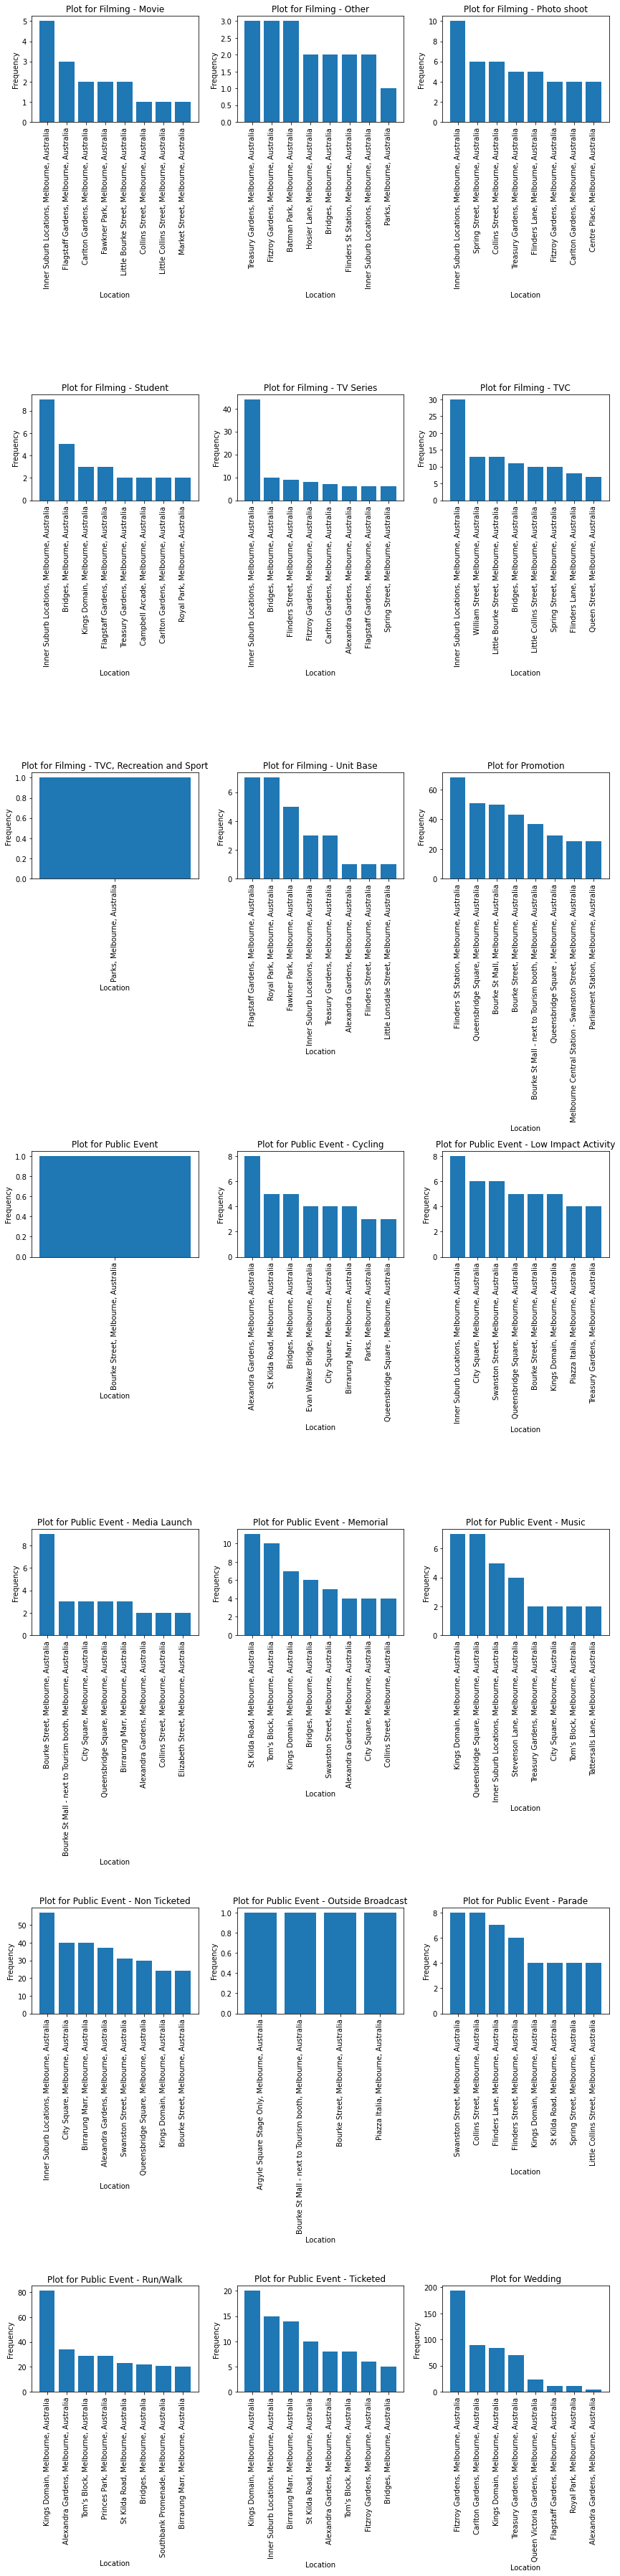

In [1523]:
top_locations={}
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(12, 50))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

location_counts = X_train.groupby(['Category', 'Location']).size().reset_index(name='Frequency')

#top 8 locations for each event
Z=location_counts.groupby('Category')
num=0
for i in Z:
    cat=i[0]
    df=pd.DataFrame(i[1])
    df=df.sort_values(by='Frequency', ascending=False)
    top_x=df['Location'][:8].values
    top_y=df['Frequency'][:8].values
    
    top_locations[cat]=top_x
    
    ax = axes[num]
   
    ax.bar(top_x, top_y, label=cat)
    ax.set_title(f'Plot for {cat}')
    ax.set_xlabel('Location')
    ax.set_ylabel('Frequency')
    ax.set_xticks(top_x)
    ax.set_xticklabels(top_x,rotation=90)
    num+=1
    

plt.tight_layout()
plt.show()

In [1524]:
print(top_locations)

{'Filming - Movie': array(['Inner Suburb Locations, Melbourne, Australia',
       'Flagstaff Gardens, Melbourne, Australia',
       'Carlton Gardens, Melbourne, Australia',
       'Fawkner Park, Melbourne, Australia',
       'Little Bourke Street, Melbourne, Australia',
       'Collins Street, Melbourne, Australia',
       'Little Collins Street, Melbourne, Australia',
       'Market Street, Melbourne, Australia'], dtype=object), 'Filming - Other': array(['Treasury Gardens, Melbourne, Australia',
       'Fitzroy Gardens, Melbourne, Australia',
       'Batman Park, Melbourne, Australia',
       'Hosier Lane, Melbourne, Australia',
       'Bridges, Melbourne, Australia',
       'Flinders St Station, Melbourne, Australia',
       'Inner Suburb Locations, Melbourne, Australia',
       'Parks, Melbourne, Australia'], dtype=object), 'Filming - Photo shoot': array(['Inner Suburb Locations, Melbourne, Australia',
       'Spring Street, Melbourne, Australia',
       'Collins Street, Melbourne, 

<b>Keeping X_train and X_test as backup dataframes with Location</b>

In [1525]:
# Loc_train=X_train['Location']
X_train_1=X_train.drop(['Location'],axis=1)
# Loc_test=X_test['Location']
X_test_1=X_test.drop(['Location'],axis=1)


<b>Encoded Category values using Binary encoding</b>

In [1526]:
binary_encoder = BinaryEncoder(cols=['Category'])

# Fit and transform the DataFrame
binary_encoder.fit(X_train_1)
X_train_1=binary_encoder.transform(X_train_1)
X_test_1=binary_encoder.transform(X_test_1)

In [1527]:
X_train_1.head()

Category_0  Category_1  Category_2  Category_3  Category_4  \
2206           0           0           0           0           1   
4016           0           0           0           1           0   
4699           0           0           0           1           1   
4006           0           0           0           1           0   
4312           0           0           0           1           1   

      Start_ordinal  End_ordinal  Duration  
2206         735505       735505         0  
4016         735797       735798         1  
4699         736603       736603         0  
4006         736363       736385        22  
4312         735280       735280         0

<b>Normalized the train and test datasets using MinMax Scaling</b>

In [1528]:
col_names = X_train_1.columns

scaler = MinMaxScaler()
scaler.fit(X_train_1[col_names])
scaled_train = scaler.transform(X_train_1[col_names])
X_train_scaled = pd.DataFrame(scaled_train, columns=col_names)

scaled_test = scaler.transform(X_test_1[col_names])
X_test_scaled = pd.DataFrame(scaled_test, columns=col_names)


In [1529]:
X_train_scaled.head()

Category_0  Category_1  Category_2  Category_3  Category_4  Start_ordinal  \
0         0.0         0.0         0.0         0.0         1.0       0.183536   
1         0.0         0.0         0.0         1.0         0.0       0.380567   
2         0.0         0.0         0.0         1.0         1.0       0.924426   
3         0.0         0.0         0.0         1.0         0.0       0.762483   
4         0.0         0.0         0.0         1.0         1.0       0.031714   

   End_ordinal  Duration  
0     0.178382  0.000000  
1     0.372679  0.002778  
2     0.906499  0.000000  
3     0.761936  0.061111  
4     0.029178  0.000000

<b>KNeighborsRegressor is used to find the neighbors for a data point. The neighbors can be used to suggest the locations for specific category of event</b>

In [1530]:
knn_model_event = KNeighborsRegressor(n_neighbors=8) #8 neighbors are considered
knn_model_event.fit(X_train_scaled, Y_train)  

Y_pred = knn_model_event.predict(X_test_scaled)

mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.015875915865681385


<b>Matching the index values of X_train_scaled and X_train</b>

In [1531]:
X_train.index=X_train_scaled.index

In [1532]:
X_test.index=X_test_scaled.index

In [1533]:
Y_train.index=X_train_scaled.index

In [1534]:
Y_test.index=X_test_scaled.index

<b>Obtaining the neighbors and neighbors' locations for X_test and finding the number of times the top locations were selected for a given event</b> 

In [1535]:
count_dict={}
neighbour_dict={'Category':[],'Latitude':[],'Longitude':[],'Location':[]}



distances, indices = knn_model_event.kneighbors(X_test_scaled)
for i in range(len(X_test_scaled)):
    per=0

    neighbor_indices = indices[i]

    for j in neighbor_indices:
        #Each neighbor point is obtained for every X_test_scaled record
        neighbour_point=X_train.iloc[j]
        category=neighbour_point['Category']
        loc=neighbour_point['Location']
        
        neighbour_dict['Category'].append(category)
        neighbour_dict['Latitude'].append(Y_train.iloc[j]['Latitude'])
        neighbour_dict['Longitude'].append(Y_train.iloc[j]['Longitude'])
        neighbour_dict['Location'].append(loc)

        
        if loc in top_locations[category]:
            per+=1
    if category not in count_dict:
        count_dict[category]=[(per/8)*100]
    else:
        count_dict[category].append((per/8)*100)
        


In [1536]:
neighbour_df=pd.DataFrame(neighbour_dict)
neighbour_df.head(15)

Category   Latitude   Longitude  \
0       Filming - Student -37.816917  144.965432   
1       Filming - Student -37.816415  144.965438   
2       Filming - Student -37.781268  144.951681   
3       Filming - Student -37.825916  144.974386   
4       Filming - Student -37.812684  144.980505   
5       Filming - Student -37.817784  144.966020   
6       Filming - Student -37.824925  144.971607   
7       Filming - Student -37.852686  145.680012   
8   Public Event - Parade -37.813744  144.968700   
9   Public Event - Parade -37.818186  144.966477   
10  Public Event - Parade -37.821972  144.971721   
11  Public Event - Parade -37.816049  144.957055   
12  Public Event - Parade -37.816917  144.965432   
13  Public Event - Parade -37.810666  144.971585   
14  Public Event - Parade -37.817637  144.958907   

                                        Location  
0            Flinders Lane, Melbourne, Australia  
1             Centre Place, Melbourne, Australia  
2               Royal Park, Melbourne, Australia  
3             Kings Domain, Melbourne, Australia  
4          Fitzroy Gardens, Melbourne, Australia  
5          Campbell Arcade, Melbourne, Australia  
6              Tom's Block, Melbourne, Australia  
7                  Bridges, Melbourne, Australia  
8    Little Collins Street, Melbourne, Australia  
9          Flinders Street, Melbourne, Australia  
10  Queen Victoria Gardens, Melbourne, Australia  
11           Bourke Street, Melbourne, Australia  
12           Flinders Lane, Melbourne, Australia  
13    Little Bourke Street, Melbourne, Australia  
14          Collins Street, Melbourne, Australia

In [1537]:
neighbour_df.shape

(6808, 4)

In [1538]:
print("The top locations were selected on average: ")
for i,j in count_dict.items():
    avg=round(sum(j)/len(j),2)
    percentage_in_train=round(X_train['Category'].value_counts().loc[i]/len(X_train)*100,2)
    variation=sum(location_counts['Category']==i)
    print(f"{avg}% of times under {i}-({percentage_in_train}%,{variation}) Category")

The top locations were selected on average: 
53.75% of times under Filming - Student-(1.65%,34) Category
52.5% of times under Public Event - Parade-(2.47%,27) Category
35.38% of times under Public Event - Non Ticketed-(22.02%,115) Category
60.58% of times under Public Event - Cycling-(1.76%,24) Category
38.34% of times under Filming - TVC-(7.56%,83) Category
60.73% of times under Public Event - Run/Walk-(12.53%,44) Category
72.1% of times under Promotion-(12.91%,36) Category
98.7% of times under Wedding-(14.47%,12) Category
67.76% of times under Public Event - Memorial-(2.0%,20) Category
40.57% of times under Filming - TV Series-(6.23%,60) Category
48.86% of times under Public Event - Ticketed-(4.97%,52) Category
46.2% of times under Public Event - Low Impact Activity-(2.79%,44) Category
75.0% of times under Filming - Movie-(0.62%,12) Category
48.21% of times under Filming - Other-(1.09%,27) Category
70.83% of times under Public Event - Music-(1.26%,19) Category
68.75% of times under P

#### PARKING

In [1688]:
parking_df.head()

lastupdated           status_timestamp  zone_number  \
0  2023-12-14T04:45:34+00:00  2023-12-14T03:41:25+00:00       7695.0   
1  2023-12-14T04:45:34+00:00  2023-12-13T06:21:58+00:00       7939.0   
2  2023-12-14T04:45:34+00:00  2023-12-13T07:44:31+00:00          NaN   
3  2023-12-14T23:45:34+00:00  2023-12-14T23:35:02+00:00          NaN   
4  2023-12-14T23:45:34+00:00  2023-12-14T22:39:46+00:00          NaN   

  status_description  kerbsideid                                 location  
0         Unoccupied       22959   -37.81844776554182, 144.95938672872117  
1         Unoccupied       10136    -37.8099909364941, 144.95263753679632  
2         Unoccupied        6992   -37.81898459198334, 144.95965213010888  
3         Unoccupied        6527   -37.81060096851364, 144.95642622505966  
4         Unoccupied        6526  -37.810581463657826, 144.95649292476088

In [1689]:
parking_df.shape

(6231, 6)

In [1690]:
parking_df.nunique()

lastupdated             30
status_timestamp      5439
zone_number            513
status_description       2
kerbsideid            6231
location              5865
dtype: int64

<b>Creating Latitude and Longitude features from Location</b>

In [1691]:
parking_lat=[]
parking_lon=[]

for i in parking_df['location']:
    x,y=i.split(",")
    parking_lat.append(float(x.strip()))
    parking_lon.append(float(y.strip()))

In [1695]:
parking_df['Latitude']=parking_lat
parking_df['Longitude']=parking_lon
parking_df.head()

lastupdated           status_timestamp  zone_number  \
0  2023-12-14T04:45:34+00:00  2023-12-14T03:41:25+00:00       7695.0   
1  2023-12-14T04:45:34+00:00  2023-12-13T06:21:58+00:00       7939.0   
2  2023-12-14T04:45:34+00:00  2023-12-13T07:44:31+00:00          NaN   
3  2023-12-14T23:45:34+00:00  2023-12-14T23:35:02+00:00          NaN   
4  2023-12-14T23:45:34+00:00  2023-12-14T22:39:46+00:00          NaN   

  status_description  kerbsideid                                 location  \
0         Unoccupied       22959   -37.81844776554182, 144.95938672872117   
1         Unoccupied       10136    -37.8099909364941, 144.95263753679632   
2         Unoccupied        6992   -37.81898459198334, 144.95965213010888   
3         Unoccupied        6527   -37.81060096851364, 144.95642622505966   
4         Unoccupied        6526  -37.810581463657826, 144.95649292476088   

    Latitude   Longitude  
0 -37.818448  144.959387  
1 -37.809991  144.952638  
2 -37.818985  144.959652  
3 -37.810601  144.956426  
4 -37.810581  144.956493

In [1696]:
parking_df.isna().sum()

lastupdated             0
status_timestamp        0
zone_number           464
status_description      0
kerbsideid              0
location                0
Latitude                0
Longitude               0
dtype: int64

<b>Only keeping the Longitude and Latitude features</b>

In [1697]:
parking_df.drop(['kerbsideid','lastupdated','status_timestamp','status_description','zone_number','location'],axis=1,inplace=True)


In [1698]:
parking_df.head()

Latitude   Longitude
0 -37.818448  144.959387
1 -37.809991  144.952638
2 -37.818985  144.959652
3 -37.810601  144.956426
4 -37.810581  144.956493

<b>Scaling the dataframe using MinMax Scaling</b>

In [1699]:
col_names=parking_df.columns


scaler = MinMaxScaler()
scaler.fit(neighbour_df[['Latitude','Longitude']])
neighbour_scaled_df=pd.DataFrame(scaler.transform(neighbour_df[['Latitude','Longitude']]),columns=['Latitude','Longitude'])


scaled_train = scaler.transform(parking_df[col_names])
parking_scaled = pd.DataFrame(scaled_train, columns=col_names)



In [1700]:
parking_scaled.head()

Latitude  Longitude
0  0.787895   0.360010
1  0.800145   0.354016
2  0.787117   0.360246
3  0.799261   0.357381
4  0.799290   0.357440

In [1701]:
neighbour_scaled_df.head()

Latitude  Longitude
0  0.790112   0.365379
1  0.790839   0.365384
2  0.841752   0.353167
3  0.777076   0.373331
4  0.796244   0.378766

<b>NearestNeighbors Algorithm to find 5 neighbors(parking locations) for each event record</b><br>
Here, the 5 neighbors for a given test record will determine the 5 closest parking locations given the longitude and latitude of an event location

In [1702]:

knn_model_parking = NearestNeighbors(n_neighbors=5, algorithm='auto')
knn_model_parking.fit(parking_scaled)


NearestNeighbors()

In [1703]:
distances, indices = knn_model_parking.kneighbors(neighbour_scaled_df)

geolocator = Nominatim(user_agent="parking_locator",timeout=5)

parking_neighbour_dict={'Event Category':[],'Event Location':[],'Event Latitude':[],'Event Longitude':[],'Parking Location':[],'Parking Latitude':[],'Parking Longitude':[]}

for i in range(len(neighbour_scaled_df)):
    neighbour_indices = indices[i]
    for j in range(len(neighbour_indices)):
        #Each neighbor point(parking spot) is obtained for every neighbour_scaled_df record
        parking_neighbour=parking_df.iloc[neighbour_indices[j]]
        parking_lat=parking_neighbour['Latitude']
        parking_lon=parking_neighbour['Longitude']
        if parking_lat in parking_neighbour_dict['Parking Latitude'] and parking_lon in parking_neighbour_dict['Parking Longitude']:
            ind=parking_neighbour_dict['Parking Latitude'].index(parking_lat)
            loc=parking_neighbour_dict['Parking Location'][ind]
            parking_neighbour_dict['Parking Location'].append(loc)
        else:
            try:
                location = geolocator.reverse((parking_lat, parking_lon), exactly_one=True)
                if location:
                    parking_neighbour_dict['Parking Location'].append(location.address)
        
            except Exception as e:
                print(f"Error: {e}")
        parking_neighbour_dict['Parking Latitude'].append(parking_lat)
        parking_neighbour_dict['Parking Longitude'].append(parking_lon)

        parking_neighbour_dict['Event Location'].append(neighbour_df['Location'].iloc[i])
        parking_neighbour_dict['Event Category'].append(neighbour_df['Category'].iloc[i])
        parking_neighbour_dict['Event Latitude'].append(neighbour_df['Latitude'].iloc[i])
        parking_neighbour_dict['Event Longitude'].append(neighbour_df['Longitude'].iloc[i])
            
        

event_parking_df=pd.DataFrame(parking_neighbour_dict)  
event_parking_df.head()


Event Category                       Event Location  Event Latitude  \
0  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
1  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
2  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
3  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
4  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   

   Event Longitude                                   Parking Location  \
0       144.965432  Punt Hill Apartment Hotel, 267, Flinders Lane,...   
1       144.965432  Tomasetti Building, 277-279, Flinders Lane, Ea...   
2       144.965432  Tomasetti Building, 277-279, Flinders Lane, Ea...   
3       144.965432  Viva Physiotherapy, 289, Flinders Lane, East E...   
4       144.965432  Ross House, 247-251, Flinders Lane, East End T...   

   Parking Latitude  Parking Longitude  
0        -37.816950         144.965422  
1        -37.817009         144.965221  
2        -37.817026         144.965165  
3        -37.817078         144.964986  
4        -37.816803         144.965927

<b>The event_parking_df contains the information of all events and the 8 most likely locations they should take place along with the 5 closest parking spot locations around each event.</b>

In [1706]:
event_parking_df.drop_duplicates(keep='first', inplace=True)
event_parking_df.head()

Event Category                       Event Location  Event Latitude  \
0  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
1  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
2  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
3  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
4  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   

   Event Longitude                                   Parking Location  \
0       144.965432  Punt Hill Apartment Hotel, 267, Flinders Lane,...   
1       144.965432  Tomasetti Building, 277-279, Flinders Lane, Ea...   
2       144.965432  Tomasetti Building, 277-279, Flinders Lane, Ea...   
3       144.965432  Viva Physiotherapy, 289, Flinders Lane, East E...   
4       144.965432  Ross House, 247-251, Flinders Lane, East End T...   

   Parking Latitude  Parking Longitude  
0        -37.816950         144.965422  
1        -37.817009         144.965221  
2        -37.817026         144.965165  
3        -37.817078         144.964986  
4        -37.816803         144.965927

In [1708]:
event_parking_df.shape

(3026, 7)

<b>Displaying the event locations and parking locations based on event categories using folium</b>

In [1790]:
def display_event_parking(event_name):

    plotted_coordinates=[]
    plotted_name=[]

    filtered_df = event_parking_df[event_parking_df['Event Category'] == event_name]
    m = folium.Map(location=[event_parking_df['Event Latitude'].mean(), event_parking_df['Event Longitude'].mean()], zoom_start=10)


    for idx, row in filtered_df.iterrows():
        
        coordinates = (row['Event Latitude'], row['Event Longitude'])
        if coordinates not in plotted_coordinates and row['Event Location'] not in plotted_name:
            folium.Marker(coordinates, popup=row['Event Location'], icon=folium.Icon(color='blue')).add_to(m)
            plotted_coordinates.append(coordinates)
            plotted_name.append(row['Event Location'])

    # Adding markers for parking locations
    for idx, row in filtered_df.iterrows():
        coordinates = (row['Parking Latitude'], row['Parking Longitude'])
        if coordinates not in plotted_coordinates:
            folium.Marker(coordinates,popup=row['Parking Location'], icon=folium.Icon(color='green')).add_to(m)
            plotted_coordinates.append(coordinates)
    display(m)

# Creating search box widget
event_search_box = widgets.Dropdown(options=event_parking_df['Event Category'].unique(), description='Event Category:')
interact(display_event_parking, event_name=event_search_box)


interactive(children=(Dropdown(description='Event Category:', options=('Filming - Student', 'Public Event - Pa…

<function __main__.display_event_parking(event_name)>

<b>The events are displayed using blue colored markers and the parking spots are displayed using green colored markers.</b>

<b>BANNER</b>

In [1714]:
banner_df.head()

asset_number                                  asset_description  \
0       1110368  Standard Banner Pole - Lansdowne St: Wellingto...   
1       1110057                    Banner Pole - Super Banner Pole   
2       1110093                    Banner Pole - Super Banner Pole   
3       1110096                    Banner Pole - Super Banner Pole   
4       1110108                    Banner Pole - Super Banner Pole   

   banner_pole_type  book_group             model_descr_lupvalue  \
0               6.0        62.0    Banner Pole - Standard Banner   
1               2.0        79.0  Banner Pole - Super Banner Pole   
2               2.0        59.0  Banner Pole - Super Banner Pole   
3               2.0        59.0  Banner Pole - Super Banner Pole   
4               2.0        59.0  Banner Pole - Super Banner Pole   

  model_no_lupvalue        lat         lon  \
0        310101-004 -37.814268  144.977428   
1        310101-001 -37.809428  144.966548   
2        310101-001 -37.800985  144.957241   
3        310101-001 -37.800974  144.957269   
4        310101-001 -37.801019  144.957138   

                                  location  
0   -37.81426836404757, 144.97742756833915  
1   -37.80942811378078, 144.96654780374206  
2    -37.80098530840636, 144.9572409533404  
3   -37.80097426523944, 144.95726931044308  
4  -37.801019397609785, 144.95713847866782

In [1715]:
banner_df.shape

(859, 9)

In [1716]:
banner_df.nunique()

asset_number            859
asset_description        85
banner_pole_type          6
book_group              104
model_descr_lupvalue      5
model_no_lupvalue         5
lat                     859
lon                     859
location                859
dtype: int64

In [1717]:
banner_df.isna().sum()

asset_number             0
asset_description        0
banner_pole_type         3
book_group               3
model_descr_lupvalue    46
model_no_lupvalue       46
lat                      0
lon                      0
location                 0
dtype: int64

<b>'model_no_lupvalue' feature and 'model_descr_lupvalue' feature are null together</b>

In [1718]:
banner_df[banner_df['model_no_lupvalue'].isna()]

asset_number                                  asset_description  \
32        1581126  Standard Banner Pole - William Street between ...   
44        1110333     Super Banner Pole Brackets - Town Hall Portico   
54        1110842     Super Banner Pole Brackets - Town Hall Portico   
77        1110698  Catenary Banner - Little Bourke St (Chinatown)...   
84        1110154  Catenary Banner - Little Bourke St (Chinatown)...   
87        1110596  Catenary Banner - Little Bourke St (Chinatown)...   
89        1581125  Standard Banner Pole - Niagara Lane between Lo...   
95        1110151  Catenary Banner - Little Bourke St (Chinatown)...   
97        1110591  Catenary Banner - Little Bourke St (Chinatown)...   
119       1110152  Catenary Banner - Little Bourke St (Chinatown)...   
128       1110690  Catenary Banner - Little Bourke St (Chinatown)...   
159       1110590  Catenary Banner - Little Bourke St (Chinatown)...   
204       1110694  Catenary Banner - Little Bourke St (Chinatown)...   
294       1110599  Catenary Banner - Little Bourke St (Chinatown)...   
306       1110153  Catenary Banner - Little Bourke St (Chinatown)...   
371       1110841     Super Banner Pole Brackets - Town Hall Portico   
374       1110594  Catenary Banner - Little Bourke St (Chinatown)...   
375       1110593  Catenary Banner - Little Bourke St (Chinatown)...   
381       1110592  Catenary Banner - Little Bourke St (Chinatown)...   
413       1110600  Catenary Banner - Little Bourke St (Chinatown)...   
417       1110597  Catenary Banner - Little Bourke St (Chinatown)...   
423       1110697  Catenary Banner - Little Bourke St (Chinatown)...   
424       1110691  Catenary Banner - Little Bourke St (Chinatown)...   
434       1110585  Catenary Banner - Little Bourke St (Chinatown)...   
435       1110840     Super Banner Pole Brackets - Town Hall Portico   
443       1110701  Catenary Banner - Little Bourke St (Chinatown)...   
455       1110150     Super Banner Pole Brackets - Town Hall Portico   
456       1110586  Catenary Banner - Little Bourke St (Chinatown)...   
466       1581127  Standard Banner Pole - Swanston Street between...   
527       1110695  Catenary Banner - Little Bourke St (Chinatown)...   
533       1110601  Catenary Banner - Little Bourke St (Chinatown)...   
561       1110588  Catenary Banner - Little Bourke St (Chinatown)...   
581       1110696  Catenary Banner - Little Bourke St (Chinatown)...   
594       1110458  Catenary Banner - Little Bourke St (Chinatown)...   
596       1110589  Catenary Banner - Little Bourke St (Chinatown)...   
634       1110598  Catenary Banner - Little Bourke St (Chinatown)...   
678       1109884  Catenary Banner - Little Bourke St (Chinatown)...   
719       1110692  Catenary Banner - Little Bourke St (Chinatown)...   
729       1110131     Super Banner Pole Brackets - Town Hall Portico   
745       1110693  Catenary Banner - Little Bourke St (Chinatown)...   
758       1110595  Catenary Banner - Little Bourke St (Chinatown)...   
815       1110700  Catenary Banner - Little Bourke St (Chinatown)...   
821       1110602  Catenary Banner - Little Bourke St (Chinatown)...   
822       1110839     Super Banner Pole Brackets - Town Hall Portico   
823       1110699  Catenary Banner - Little Bourke St (Chinatown)...   
829       1110587  Catenary Banner - Little Bourke St (Chinatown)...   

     banner_pole_type  book_group model_descr_lupvalue model_no_lupvalue  \
32                6.0        19.0                  NaN               NaN   
44                7.0        28.0                  NaN               NaN   
54                7.0        28.0                  NaN               NaN   
77                8.0       117.0                  NaN               NaN   
84                8.0       117.0                  NaN               NaN   
87                8.0        18.0                  NaN               NaN   
89                6.0        19.0                  NaN               NaN   
95          

<b>Checking the 'model_descr_lupvalue' for each 'banner_pole_type'</b>

In [1719]:
banner_df['banner_pole_type'].value_counts()

6.0    378
2.0    362
4.0     59
8.0     36
5.0     14
7.0      7
Name: banner_pole_type, dtype: int64

In [1720]:
print(banner_df.loc[banner_df['banner_pole_type']==6.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==2.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==4.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==8.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==5.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==7.0,'model_descr_lupvalue'].unique())

['Banner Pole - Standard Banner' nan]
['Banner Pole - Super Banner Pole' 'Banner Pole - Spinner'
 'Banner Pole - Standard Banner']
['Banner Pole - Type 1 - Docklands']
[nan]
['Banner Pole - Type 2 - Docklands']
[nan]


<b>Replacing the nan valus for 7.0 and 8.0 banner_pole_type using the first part of the asset_description</b>

In [1721]:
banner_df['model_descr_lupvalue']=banner_df.apply(lambda row: row['asset_description'].split(' - ')[0] if row['banner_pole_type']==7.0 else row['model_descr_lupvalue'], axis=1)


In [1722]:
banner_df['model_descr_lupvalue']=banner_df.apply(lambda row: row['asset_description'].split(' - ')[0] if row['banner_pole_type']==8.0 else row['model_descr_lupvalue'], axis=1)


<b>6.0 banner_pole_type is always Standard Banner</b>

In [1723]:
banner_df['model_descr_lupvalue'].fillna('Banner Pole - Standard Banner',inplace=True)

In [1724]:
print(banner_df.loc[banner_df['banner_pole_type']==6.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==2.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==4.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==8.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==5.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==7.0,'model_descr_lupvalue'].unique())

['Banner Pole - Standard Banner']
['Banner Pole - Super Banner Pole' 'Banner Pole - Spinner'
 'Banner Pole - Standard Banner']
['Banner Pole - Type 1 - Docklands']
['Catenary Banner']
['Banner Pole - Type 2 - Docklands']
['Super Banner Pole Brackets']


<b>Checking banner_pole_type=2.0 with a Standard Banner model_descr_lupvalue which does not match with asset_description</b>

In [1725]:
banner_df[(banner_df['banner_pole_type']==2.0) & (banner_df['model_descr_lupvalue']=='Banner Pole - Standard Banner')]


asset_number                                  asset_description  \
195       1109886  Super Banner Pole - Bourke St: Exhibition St -...   

     banner_pole_type  book_group           model_descr_lupvalue  \
195               2.0         7.0  Banner Pole - Standard Banner   

    model_no_lupvalue       lat         lon  \
195        310101-004 -37.81263  144.968421   

                                   location  
195  -37.812629612297506, 144.9684207947835

In [1726]:
banner_df.iloc[195,[4,5]]=['Banner Pole - Super Banner Pole','310101-001']

In [1727]:
print(banner_df.loc[banner_df['banner_pole_type']==6.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==2.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==4.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==8.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==5.0,'model_descr_lupvalue'].unique())
print(banner_df.loc[banner_df['banner_pole_type']==7.0,'model_descr_lupvalue'].unique())

['Banner Pole - Standard Banner']
['Banner Pole - Super Banner Pole' 'Banner Pole - Spinner']
['Banner Pole - Type 1 - Docklands']
['Catenary Banner']
['Banner Pole - Type 2 - Docklands']
['Super Banner Pole Brackets']


<b>Saving the 'banner_pole_type' and description in a dictionary</b>

In [1728]:
banner_name_dict={6.0:['Banner Pole - Standard Banner'],2.0:['Banner Pole - Super Banner Pole' 'Banner Pole - Spinner'],4.0:['Banner Pole - Type 1 - Docklands'],5.0:['Banner Pole - Type 2 - Docklands'],7.0:['Super Banner Pole Brackets'],8.0:['Catenary Banner']}

<b>Keeping only the banner_pole_type, lat and lon features</b>

In [1729]:
banner_df.drop(['asset_number','asset_description','book_group','model_descr_lupvalue','model_no_lupvalue','location'],axis=1,inplace=True)
banner_df.head()

banner_pole_type        lat         lon
0               6.0 -37.814268  144.977428
1               2.0 -37.809428  144.966548
2               2.0 -37.800985  144.957241
3               2.0 -37.800974  144.957269
4               2.0 -37.801019  144.957138

In [1730]:
banner_df.columns=['Banner Pole Type','Latitude','Longitude']

<b>Scaling the Latitude and Longitude using MinMax scaler</b>

In [1731]:
col_names = ['Latitude','Longitude']
temp_df=event_parking_df.copy()[['Event Latitude','Event Longitude']]
temp_df.columns=col_names


scaler = MinMaxScaler()
scaler.fit(temp_df)
neighbour_scaled_banner=pd.DataFrame(scaler.transform(temp_df),columns=col_names)

scaled_train = scaler.transform(banner_df[col_names])
banner_scaled = pd.DataFrame(scaled_train, columns=col_names)
banner_scaled.head()

Latitude  Longitude
0  0.793949   0.376032
1  0.800960   0.366370
2  0.813190   0.358104
3  0.813206   0.358130
4  0.813141   0.358013

<b>NearestNeighbors Algorithm to find 5 neighbors(banner locations) for each event record</b><br>
Here the 5 nearest neighbours will determine the 5 closest banner spots for any given event longitude and latitude given for promotional activities.


In [1732]:
knn_model_banner = NearestNeighbors(n_neighbors=5, algorithm='auto')
knn_model_banner.fit(banner_scaled)

NearestNeighbors()

In [1766]:
distances, indices = knn_model_banner.kneighbors(neighbour_scaled_banner)

geolocator = Nominatim(user_agent="banner_locator",timeout=5)


banner_neighbour_dict={'Event Category':[],'Event Location':[],'Event Latitude':[],'Event Longitude':[],'Parking Location':[],'Parking Latitude':[],'Parking Longitude':[],'Banner Pole Type':[],'Banner Latitude':[],'Banner Longitude':[],'Banner Location':[]}

for i in range(len(neighbour_scaled_banner)):
    neighbour_indices = indices[i]

    for j in range(len(neighbour_indices)):
        banner_neighbour=banner_df.iloc[neighbour_indices[j]]
        banner_lat=banner_neighbour['Latitude']
        banner_lon=banner_neighbour['Longitude']
        if banner_lat in banner_neighbour_dict['Banner Latitude'] and banner_lon in banner_neighbour_dict['Banner Longitude']:
            ind=banner_neighbour_dict['Banner Latitude'].index(banner_lat)
            loc=banner_neighbour_dict['Banner Location'][ind]
            banner_neighbour_dict['Banner Location'].append(loc)
        else:
            try:
                location = geolocator.reverse((banner_lat, banner_lon), exactly_one=True)
                if location:
                    banner_neighbour_dict['Banner Location'].append(location.address)
        
            except Exception as e:
                print(f"Error: {e}")
        banner_neighbour_dict['Banner Latitude'].append(banner_lat)
        banner_neighbour_dict['Banner Longitude'].append(banner_lon)
        banner_neighbour_dict['Banner Pole Type'].append(banner_neighbour['Banner Pole Type'])


        banner_neighbour_dict['Event Location'].append(event_parking_df['Event Location'].iloc[i])
        banner_neighbour_dict['Event Category'].append(event_parking_df['Event Category'].iloc[i])
        banner_neighbour_dict['Event Latitude'].append(event_parking_df['Event Latitude'].iloc[i])
        banner_neighbour_dict['Event Longitude'].append(event_parking_df['Event Longitude'].iloc[i])
        banner_neighbour_dict['Parking Latitude'].append(event_parking_df['Parking Latitude'].iloc[i])
        banner_neighbour_dict['Parking Longitude'].append(event_parking_df['Parking Longitude'].iloc[i])
        banner_neighbour_dict['Parking Location'].append(event_parking_df['Parking Location'].iloc[i])

            
        

event_parking_banner_df=pd.DataFrame(banner_neighbour_dict)  
event_parking_banner_df.head()


Event Category                       Event Location  Event Latitude  \
0  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
1  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
2  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
3  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   
4  Filming - Student  Flinders Lane, Melbourne, Australia      -37.816917   

   Event Longitude                                   Parking Location  \
0       144.965432  Punt Hill Apartment Hotel, 267, Flinders Lane,...   
1       144.965432  Punt Hill Apartment Hotel, 267, Flinders Lane,...   
2       144.965432  Punt Hill Apartment Hotel, 267, Flinders Lane,...   
3       144.965432  Punt Hill Apartment Hotel, 267, Flinders Lane,...   
4       144.965432  Punt Hill Apartment Hotel, 267, Flinders Lane,...   

   Parking Latitude  Parking Longitude  Banner Pole Type  Banner Latitude  \
0         -37.81695         144.965422               6.0       -37.817331   
1         -37.81695         144.965422               6.0       -37.816649   
2         -37.81695         144.965422               6.0       -37.817105   
3         -37.81695         144.965422               6.0       -37.816757   
4         -37.81695         144.965422               6.0       -37.817793   

   Banner Longitude                                    Banner Location  
0        144.964711  Om, 28, Elizabeth Street, East End Theatre Dis...  
1        144.964388  Elizabeth Street, East End Theatre District, M...  
2        144.964341  Elizabeth Street, East End Theatre District, M...  
3        144.964176  65, Elizabeth Street, East End Theatre Distric...  
4        144.965939  CoCo Fresh Tea & Juice, 258, Flinders Street, ...

<b>The event_parking_banner_df contains the complete information of all events and the 8 most likely locations they should take place, the 5 closest parking locations for each event and also the 5 closest banner spots for promoting each event.</b>

In [1768]:
event_parking_banner_df.shape

(15130, 11)

<b>Displaying the event locations, parking locations and banner locations based on event categories using folium</b>

In [1791]:
def display_event_parking_banner(event_name):



    
    filtered_df = event_parking_banner_df[event_parking_banner_df['Event Category'] == event_name]
    plotted_coordinates=[]
    plotted_name=[]

    
    map_center = [filtered_df['Event Latitude'].mean(), filtered_df['Event Longitude'].mean()]
    n = folium.Map(location=map_center, zoom_start=10)

    # Adding markers for event locations
    for idx, row in filtered_df.iterrows():
        
        coordinates = (row['Event Latitude'], row['Event Longitude'])
        if coordinates not in plotted_coordinates and row['Event Location'] not in plotted_name:
            folium.Marker(coordinates, popup=row['Event Location'], icon=folium.Icon(color='blue')).add_to(n)
            plotted_coordinates.append(coordinates)
            plotted_name.append(row['Event Location'])

    # Adding markers for parking locations
    for idx, row in filtered_df.iterrows():
        coordinates = (row['Parking Latitude'], row['Parking Longitude'])
        if coordinates not in plotted_coordinates:
            folium.Marker(coordinates,popup=row['Parking Location'], icon=folium.Icon(color='green')).add_to(n)
            plotted_coordinates.append(coordinates)
            
    # Adding markers for banner locations
    for idx, row in filtered_df.iterrows():
        coordinates = (row['Banner Latitude'], row['Banner Longitude'])
        if coordinates not in plotted_coordinates:
            folium.Marker(coordinates,popup=row[['Banner Pole Type','Banner Location']], icon=folium.Icon(color='orange')).add_to(n)
            plotted_coordinates.append(coordinates)
            
    

    display(n)

# Creating search box widget
event_search_box = widgets.Dropdown(options=event_parking_banner_df['Event Category'].unique(), description='Event:')
interact(display_event_parking_banner, event_name=event_search_box)

interactive(children=(Dropdown(description='Event:', options=('Filming - Student', 'Public Event - Parade', 'P…

<function __main__.display_event_parking_banner(event_name)>

<b>The events are displayed using blue colored markers, the parking spots are displayed using green colored markers and the banner spots are displayed using orange colored markers.</b><br>
Using this map, an event planner can select any event and view the map for possible event locations, nearest parking spots and banner locations.

<b>References</b><br>
Melbourne City Council [Economic Development Strategy 2031](https://www.melbourne.vic.gov.au/about-council/vision-goals/Pages/economic-development-strategy-2031.aspx)